# Processamento de Dados
___

In [2]:
import os 
import sys
from pathlib import Path 
sys.path.insert(1 ,os.path.dirname(Path(os.path.abspath("__file__")).resolve().parent))

import folium
import pickle
import numpy as np
import pandas as pd
from geopy import Point, Nominatim
from geopy.distance import geodesic
import itertools 

from config.params import params
from src.places_api import PlacesAPI
from src.data_process import *

## Demanda

In [4]:
raw_demand = pd.read_csv("../data/raw/saopauloln1_demand.csv")

raw_demand = raw_demand.loc[raw_demand["demand"] > 0, ['to', 'demand']].sort_values(by="to").reset_index(drop=True).copy()
raw_demand.rename(columns={"to": "Cliente", "demand": "Demanda"}, inplace=True)
raw_demand["Cliente"] = raw_demand["Cliente"].astype(str)
raw_demand["Cliente"] = "C"+raw_demand["Cliente"]
raw_demand = raw_demand.groupby(by=["Cliente"], as_index=False, dropna=False).agg({"Demanda": "sum"})

raw_demand = raw_demand[["Cliente", "Demanda"]].copy()
raw_demand.to_csv("../data/input/customer_demand.csv", index=False, sep=";", decimal=".")
raw_demand

Cliente  Demanda
0        C1    35.73
1       C10    21.42
2      C100    16.67
3      C101   111.97
4      C102    35.73
..      ...      ...
319     C94    26.20
320     C95    30.96
321     C97     9.52
322     C98     2.38
323     C99     7.14

[324 rows x 2 columns]

In [14]:
from src.CoG import calculate_center_of_gravity

cog = df_plot[['Latitude', 'Longitude', 'Demanda']].to_records('list').tolist()
cog = [(row[1], row[2], row[3]) for row in cog]
calculate_center_of_gravity(cog)


(-23.59719325641428, -46.64009486192702)

## Localizações

In [5]:
raw_nodes = pd.read_csv("../data/raw/saopauloln1_nodes.csv")
raw_nodes.drop(columns=["terminal"], inplace=True)
raw_nodes.rename(columns={"id": "ID", "lat": "Latitude", "lon": "Longitude"}, inplace=True)
raw_nodes["ID"] = "C"+raw_nodes["ID"].astype(str)
raw_nodes["Tipo"] = "Cliente"

raw_nodes.to_csv("../data/input/customer_location.csv", index=False, sep=";", decimal=".")
raw_nodes

ID   Latitude  Longitude     Tipo
0      C1 -23.555544 -46.663066  Cliente
1      C2 -23.558080 -46.660255  Cliente
2      C3 -23.561782 -46.656005  Cliente
3      C4 -23.567471 -46.649014  Cliente
4      C5 -23.579056 -46.661421  Cliente
..    ...        ...        ...      ...
338  C343 -23.525540 -46.671556  Cliente
339  C344 -23.538907 -46.607219  Cliente
340  C345 -23.543500 -46.590097  Cliente
341  C346 -23.547064 -46.646023  Cliente
342  C347 -23.523689 -46.546097  Cliente

[343 rows x 4 columns]

In [8]:
df_ = pd.merge(raw_demand, raw_nodes, how="left", left_on="Cliente", right_on="ID")
df_.to_clipboard(excel=True, index=False, sep=";", decimal=".")

In [7]:
df_[df_["Demanda"].isna()]

Empty DataFrame
Columns: [Cliente, Demanda, ID, Latitude, Longitude, Tipo]
Index: []

In [17]:
total_response = get_charging_stations()
df = process_data(total_response)
df

C:\Users\LEDmundo\Downloads\tcc\EVRP\src\data_process.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Potência de Recarga"] = df["Potência de Recarga"].fillna(df["Potência de Recarga"].mean())


ID   Latitude  Longitude                Tipo  Potência de Recarga
0        R1 -23.571065 -46.647016  Estação de Recarga                   22
1        R2 -23.548067 -46.756977  Estação de Recarga                   25
2        R3 -23.567012 -46.664722  Estação de Recarga                   25
3        R4 -23.582762 -46.649762  Estação de Recarga                   48
4        R5 -23.573742 -46.641975  Estação de Recarga                   25
...     ...        ...        ...                 ...                  ...
1299  R1300 -23.668038 -46.531930  Estação de Recarga                    6
1300  R1301 -23.523349 -46.740630  Estação de Recarga                    6
1301  R1302 -23.493144 -46.848683  Estação de Recarga                    6
1302  R1303 -23.636513 -46.543008  Estação de Recarga                   25
1303  R1304 -23.530986 -46.737544  Estação de Recarga                   25

[1304 rows x 5 columns]

In [18]:
df_plot = pd.merge(
    raw_nodes, raw_demand, how="left",
    right_on="Cliente", left_on="ID"
)
df_plot = df_plot.groupby(["ID", "Latitude", "Longitude", "Tipo"]).agg({"Demanda": "sum"}).reset_index()
df_plot["Demanda"] = df_plot["Demanda"].fillna(0)


In [ ]:
df_plot = pd.concat([df_plot, df], ignore_index=True)
df_plot

ID   Latitude  Longitude                Tipo  Demanda  \
0        C1 -23.555544 -46.663066             Cliente    35.73   
1       C10 -23.553282 -46.672525             Cliente    21.42   
2      C100 -23.644742 -46.703183             Cliente    16.67   
3      C101 -23.644570 -46.726490             Cliente   111.97   
4      C102 -23.653036 -46.680014             Cliente    35.73   
...     ...        ...        ...                 ...      ...   
1642  R1300 -23.668038 -46.531930  Estação de Recarga      NaN   
1643  R1301 -23.523349 -46.740630  Estação de Recarga      NaN   
1644  R1302 -23.493144 -46.848683  Estação de Recarga      NaN   
1645  R1303 -23.636513 -46.543008  Estação de Recarga      NaN   
1646  R1304 -23.530986 -46.737544  Estação de Recarga      NaN   

      Potência de Recarga  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
...                   ...  
1642                  6.0  
1643                  6.0  
1644                  6.0  
1645                 25.0  
1646                 25.0  

[1647 rows x 6 columns]


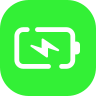
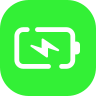
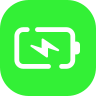
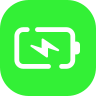
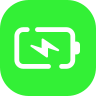
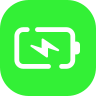
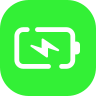
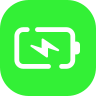
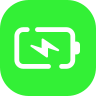
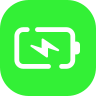
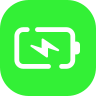
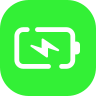
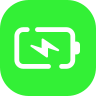
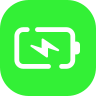
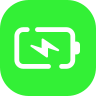
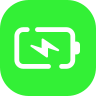
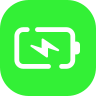
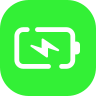
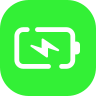
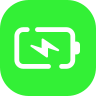
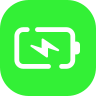
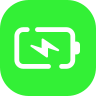
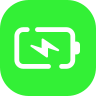
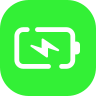
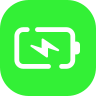
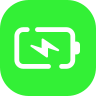
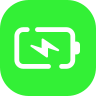
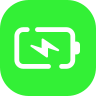
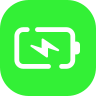
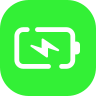
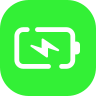
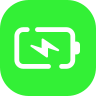
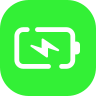
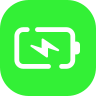
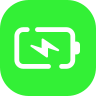
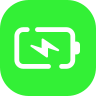
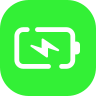
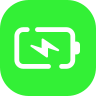
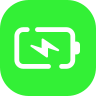
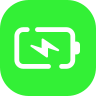
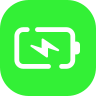
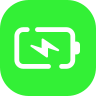
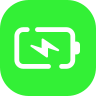
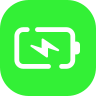
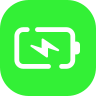
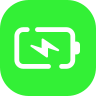
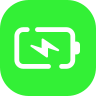
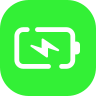
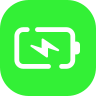
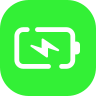
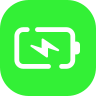
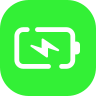
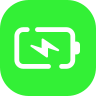
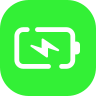
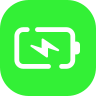
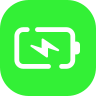
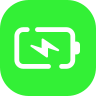
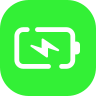
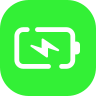
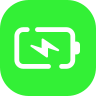
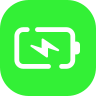
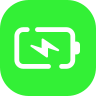
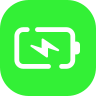
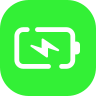
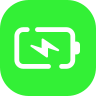
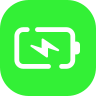
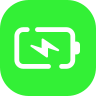
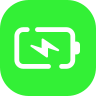
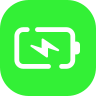
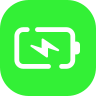
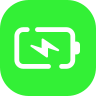
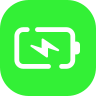
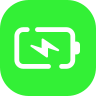
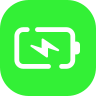
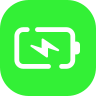
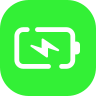
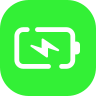
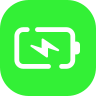
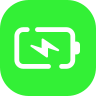
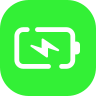
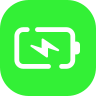
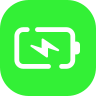
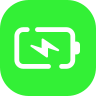
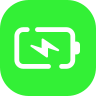
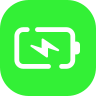
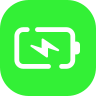
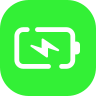
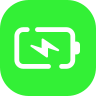
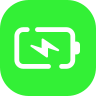
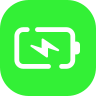
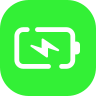
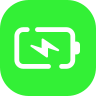
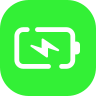
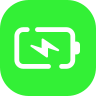
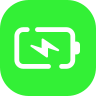
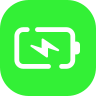
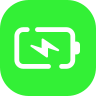
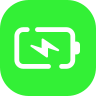
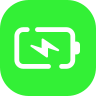
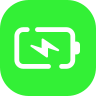
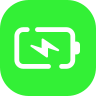
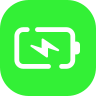
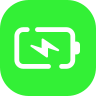
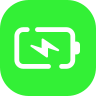
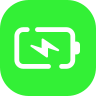
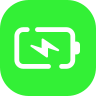
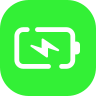
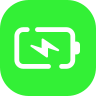
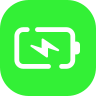
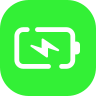
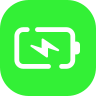
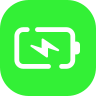
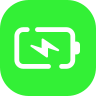
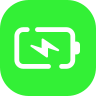
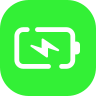
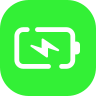
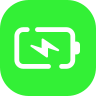
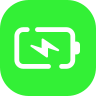
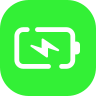
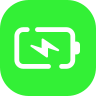
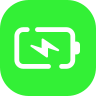
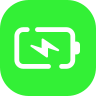
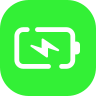
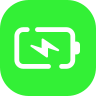
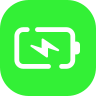
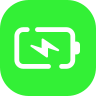
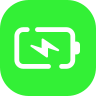
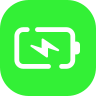
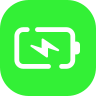
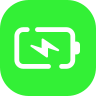
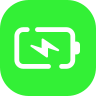
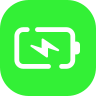
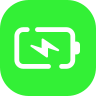
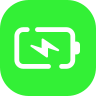
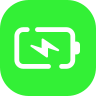
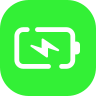
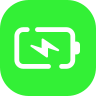
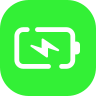
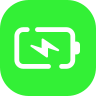
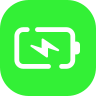
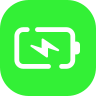
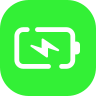
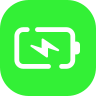
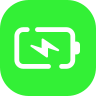
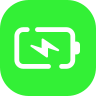
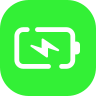
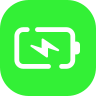
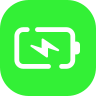
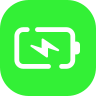
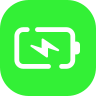
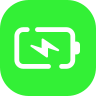
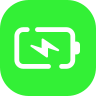
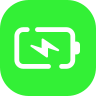
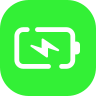
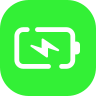
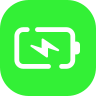
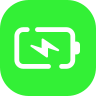
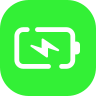
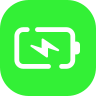
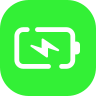
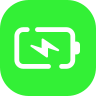
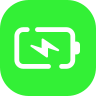
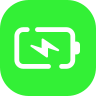
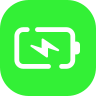
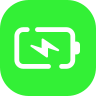
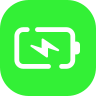
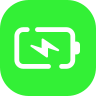
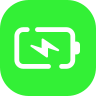
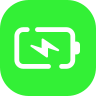
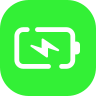
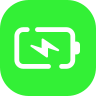
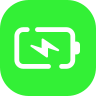
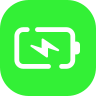
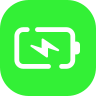
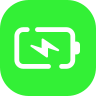
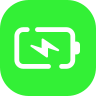
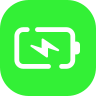
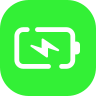
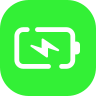
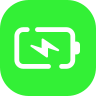
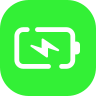
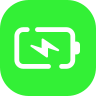
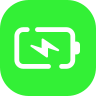
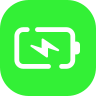
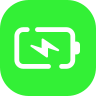
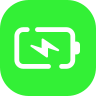
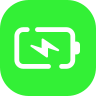
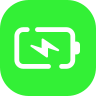
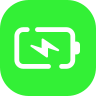
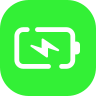
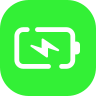
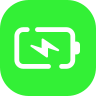
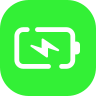
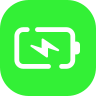
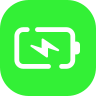
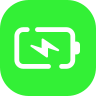
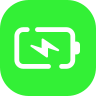
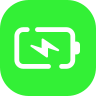
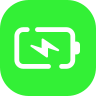
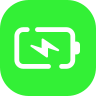
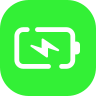
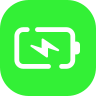
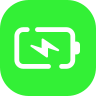
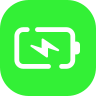
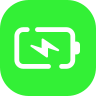
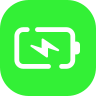
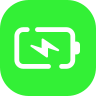
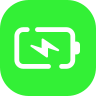
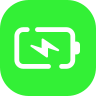
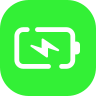
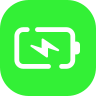
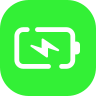
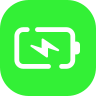
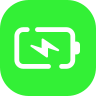
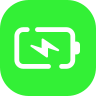
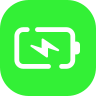
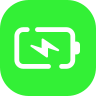
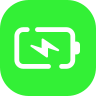
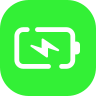
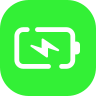
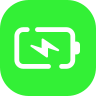
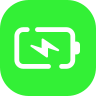
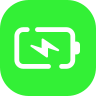
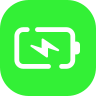
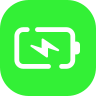
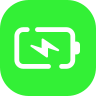
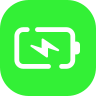
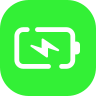
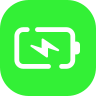
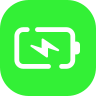
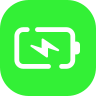
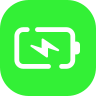
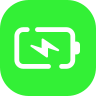
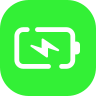
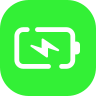
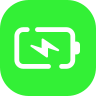
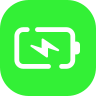
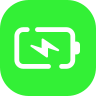
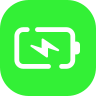
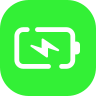
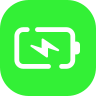
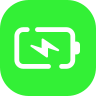
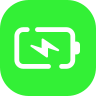
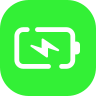
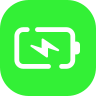
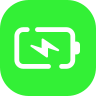
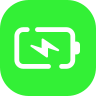
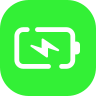
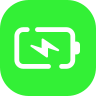
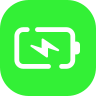
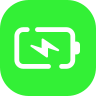
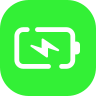
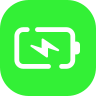
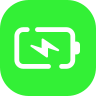
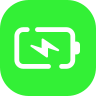
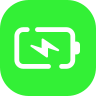
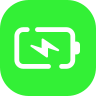
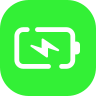
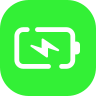
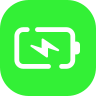
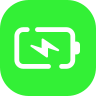
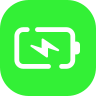
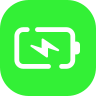
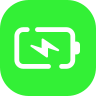
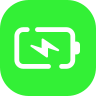
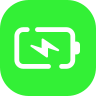
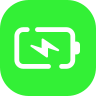
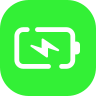
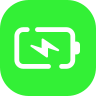
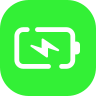
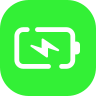
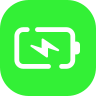
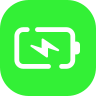
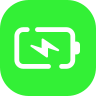
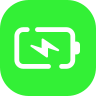
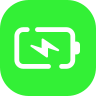
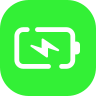
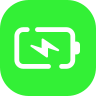
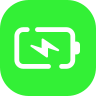
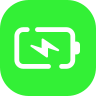
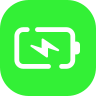
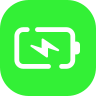
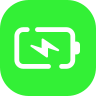
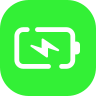
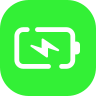
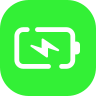
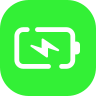
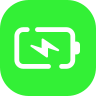
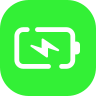
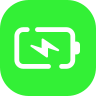
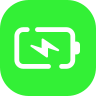
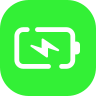
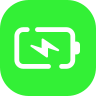
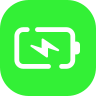
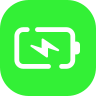
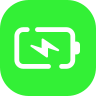
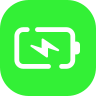
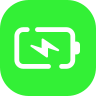
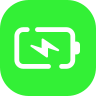
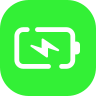
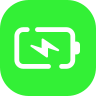
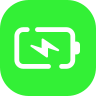
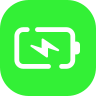
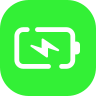
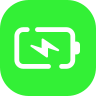
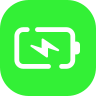
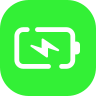
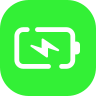
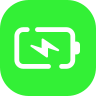
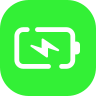
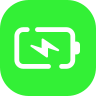
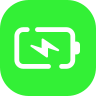
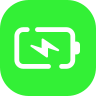
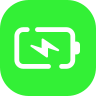
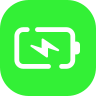
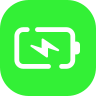
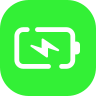
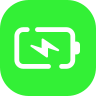
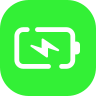
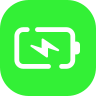
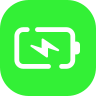
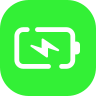
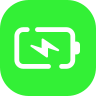
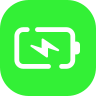
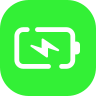
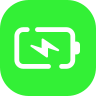
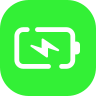
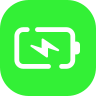
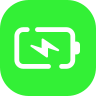
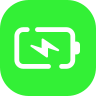
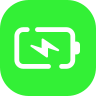
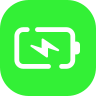
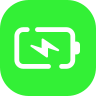
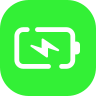
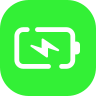
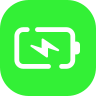
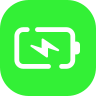
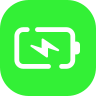
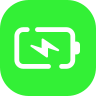
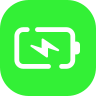
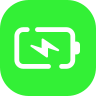
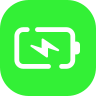
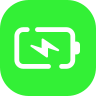
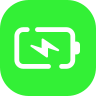
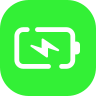
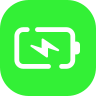
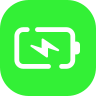
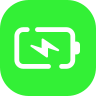
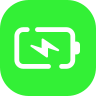
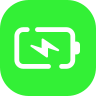
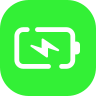
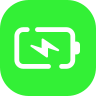
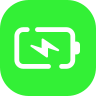
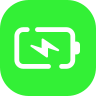
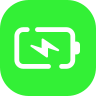
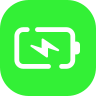
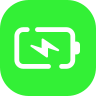
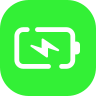
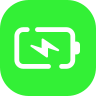
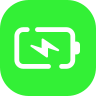
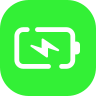
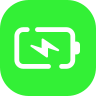
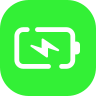
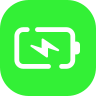
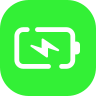
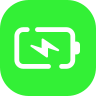
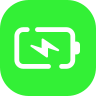
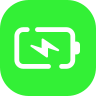
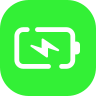
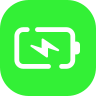
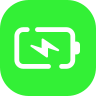
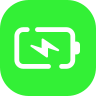
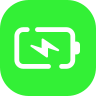
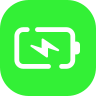
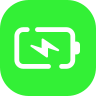
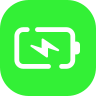
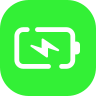
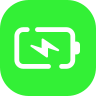
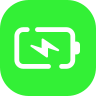
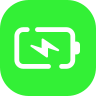
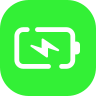
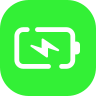
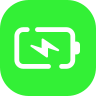
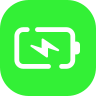
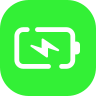
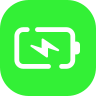
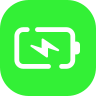
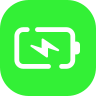
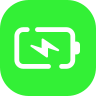
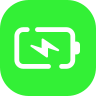
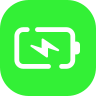
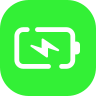
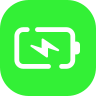
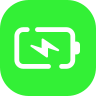
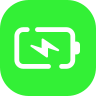
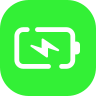
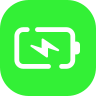
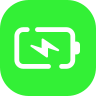
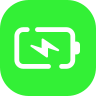
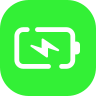
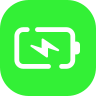
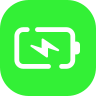
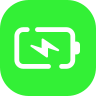
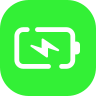
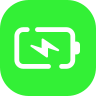
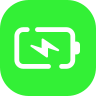
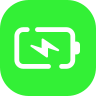
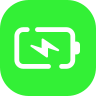
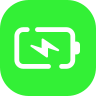
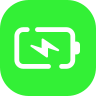
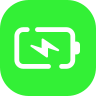
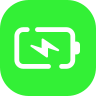
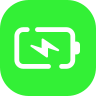
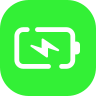
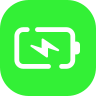
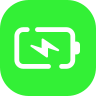
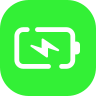
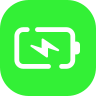
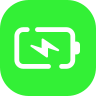
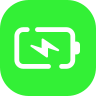
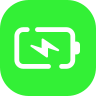
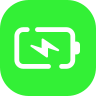
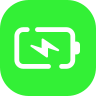
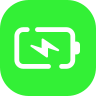
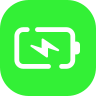
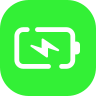
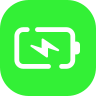
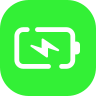
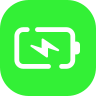
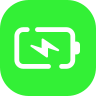
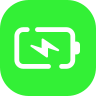
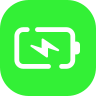
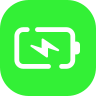
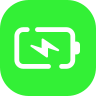
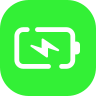
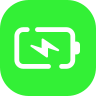
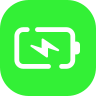
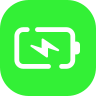
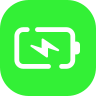
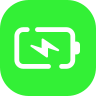
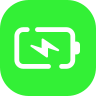
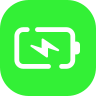
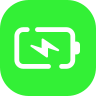
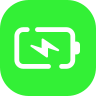
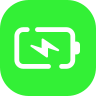
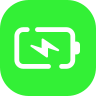
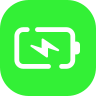
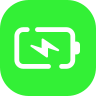
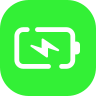
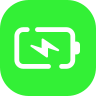
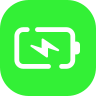
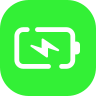
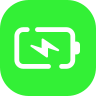
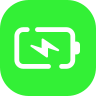
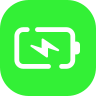
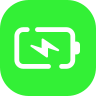
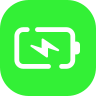
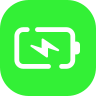
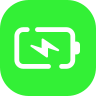
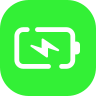
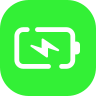
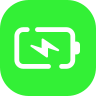
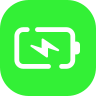
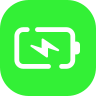
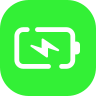
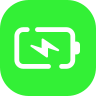
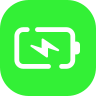
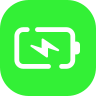
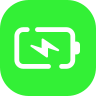
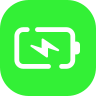
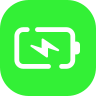
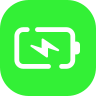
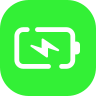
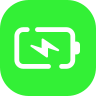
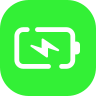
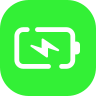
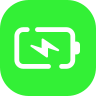
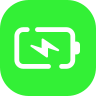
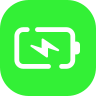
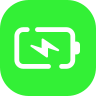
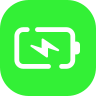
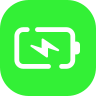
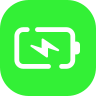
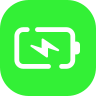
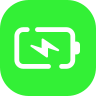
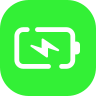
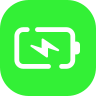
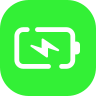
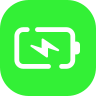
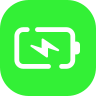
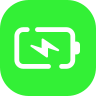
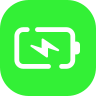
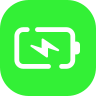
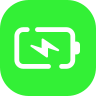
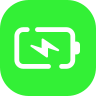
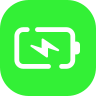
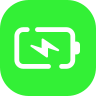
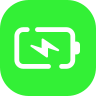
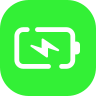
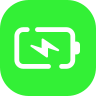
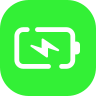
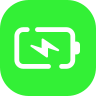
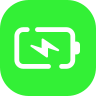
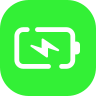
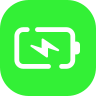
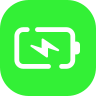
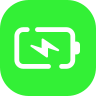
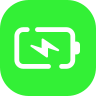
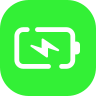
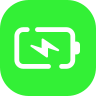
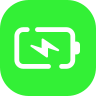
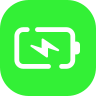
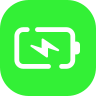
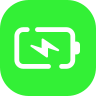
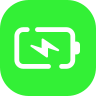
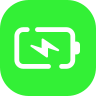
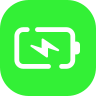
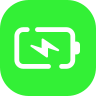
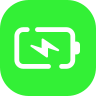
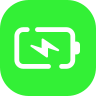
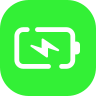
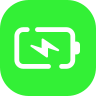
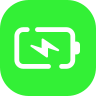
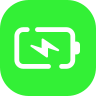
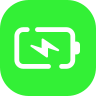
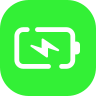
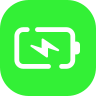
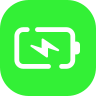
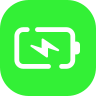
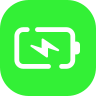
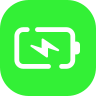
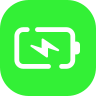
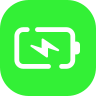
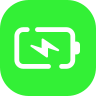
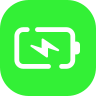
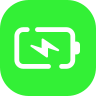
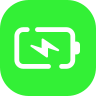
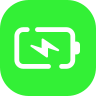
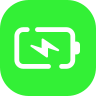
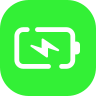
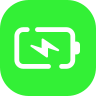
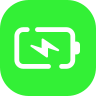
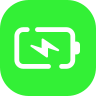
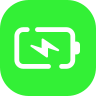
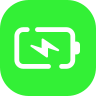
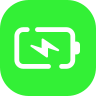
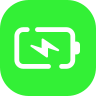
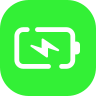
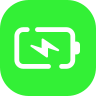
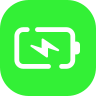
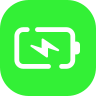
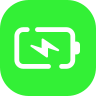
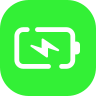
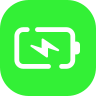
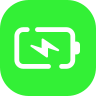
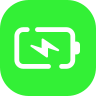
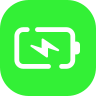
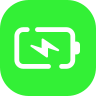
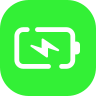
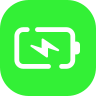
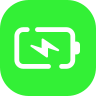
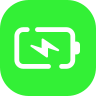
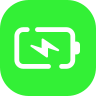
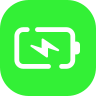
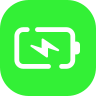
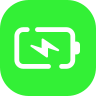
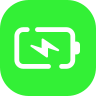
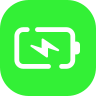
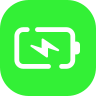
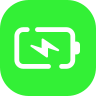
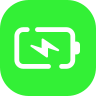
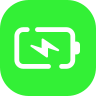
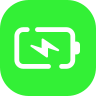
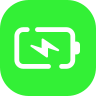
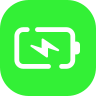
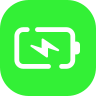
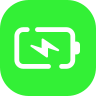
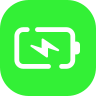
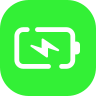
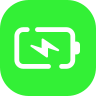
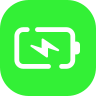
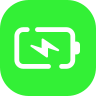
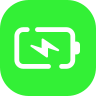
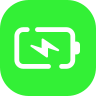
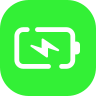
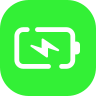
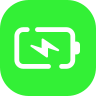
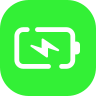
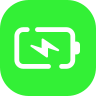
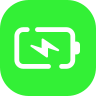
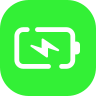
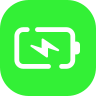
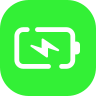
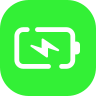
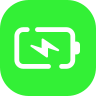
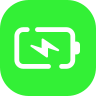
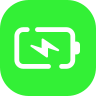
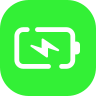
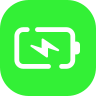
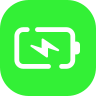
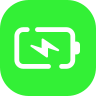
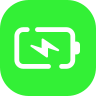
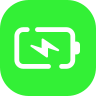
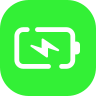
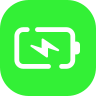
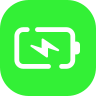
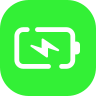
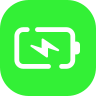
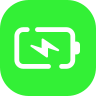
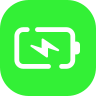
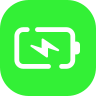
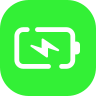
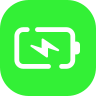
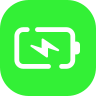
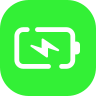
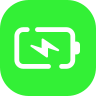
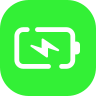
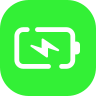
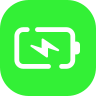
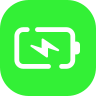
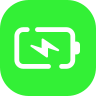
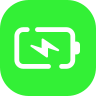
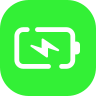
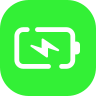
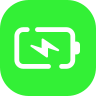
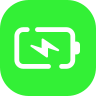
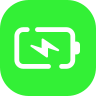
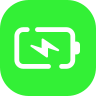
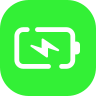
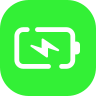
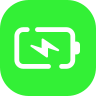
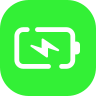
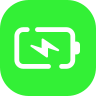
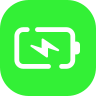
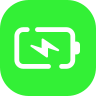
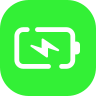
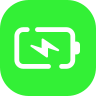
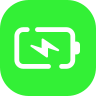
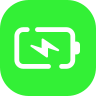
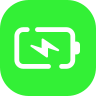
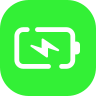
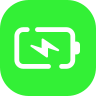
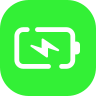
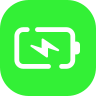
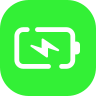
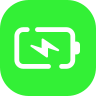
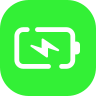
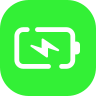
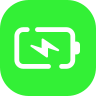
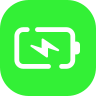
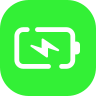
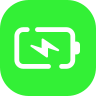
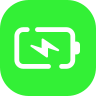
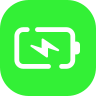
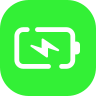
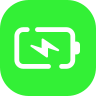
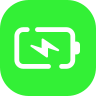
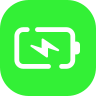
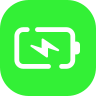
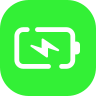
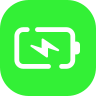
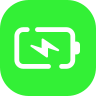
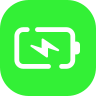
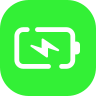
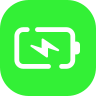
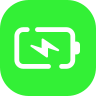
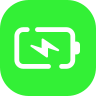
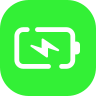
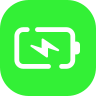
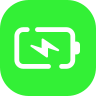
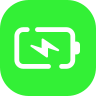
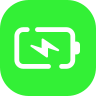
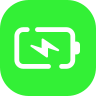
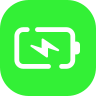
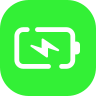
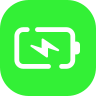
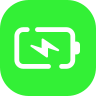
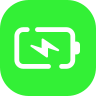
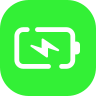
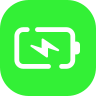
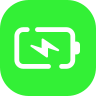
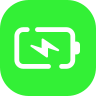
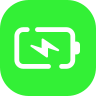
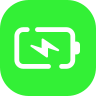
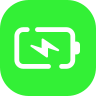
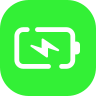
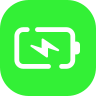
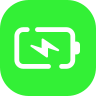
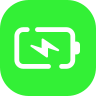
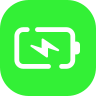
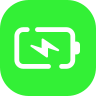
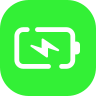
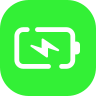
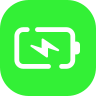
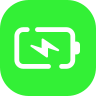
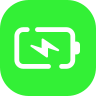
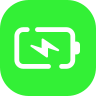
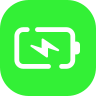
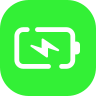
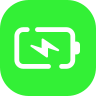
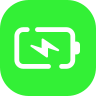
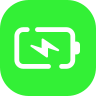
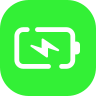
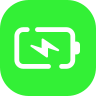
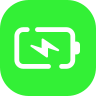
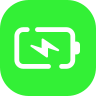
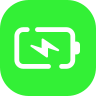
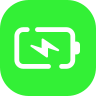
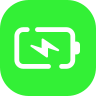
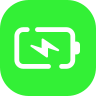
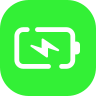
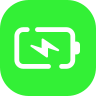
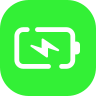
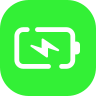
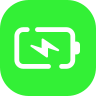
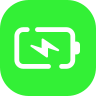
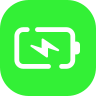
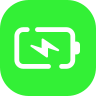
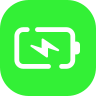
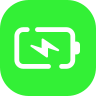
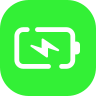
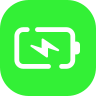
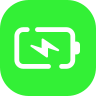
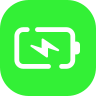
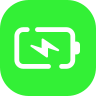
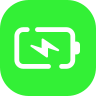
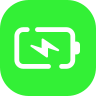
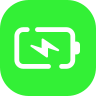
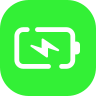
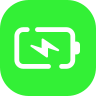
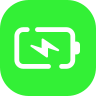
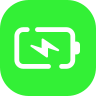
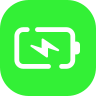
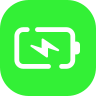
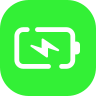
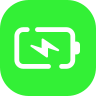
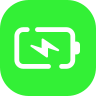
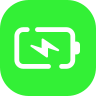
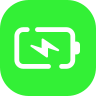
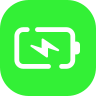
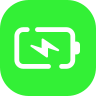
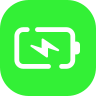
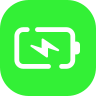
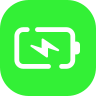
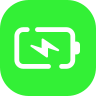
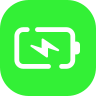
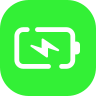
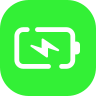
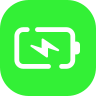
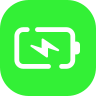
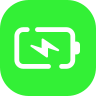
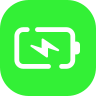
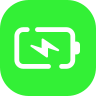
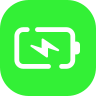
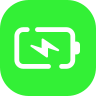
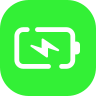
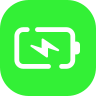
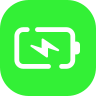
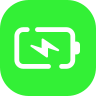
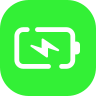
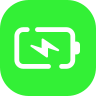
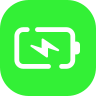
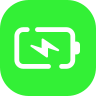
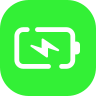
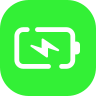
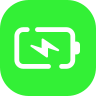
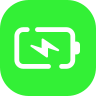
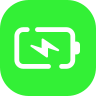
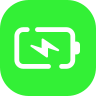
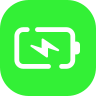
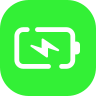
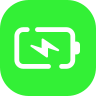
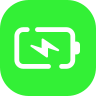
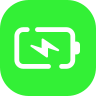
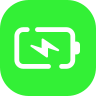
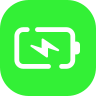
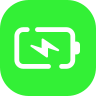
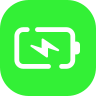
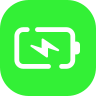
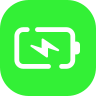
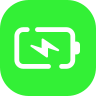
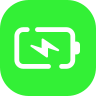
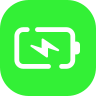
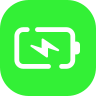
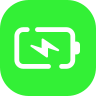
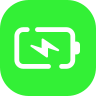
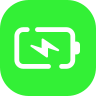
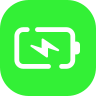
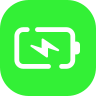
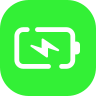
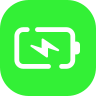
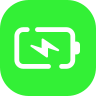
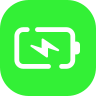
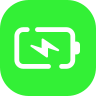
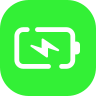
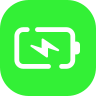
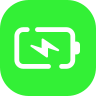
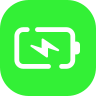
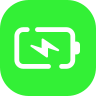
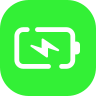
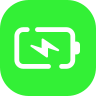
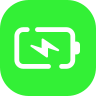
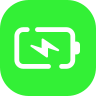
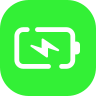
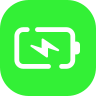
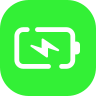
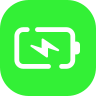
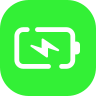
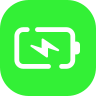
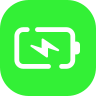
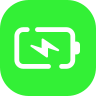
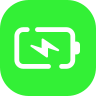
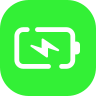
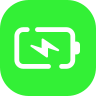
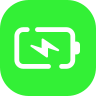
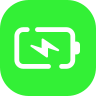
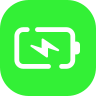
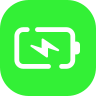
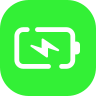
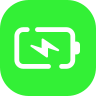
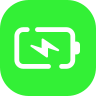
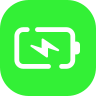
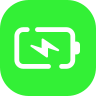
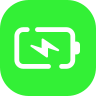
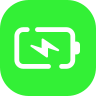
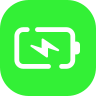
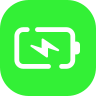
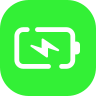
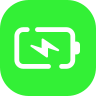
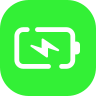
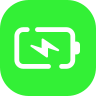
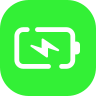
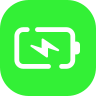
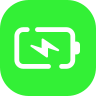
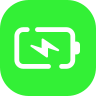
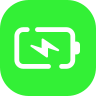
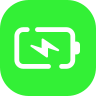
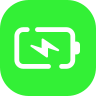
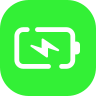
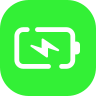
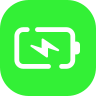
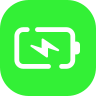
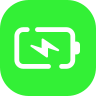
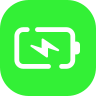
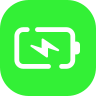
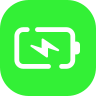
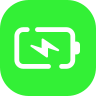
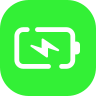
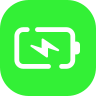
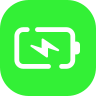
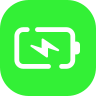
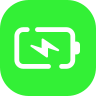
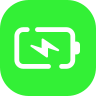
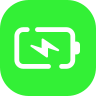
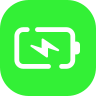
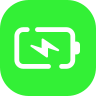
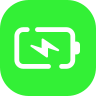
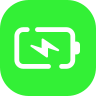
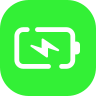
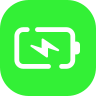
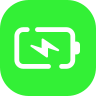
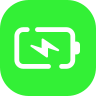
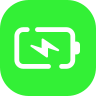
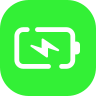
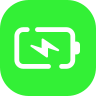
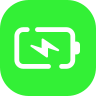
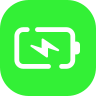
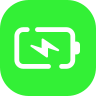
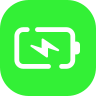
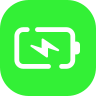
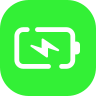
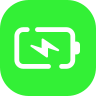
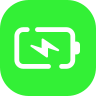
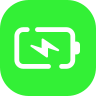
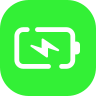
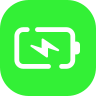
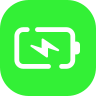
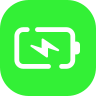
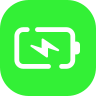
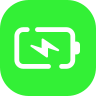
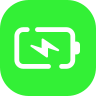
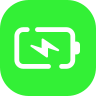
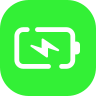
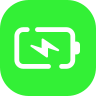
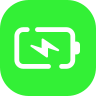
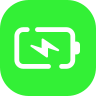
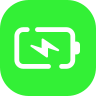
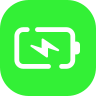
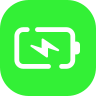
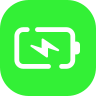
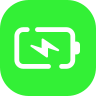
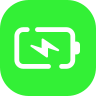
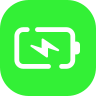
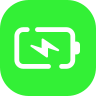
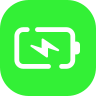
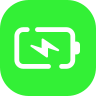
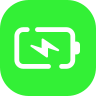
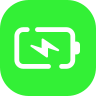
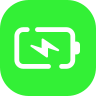
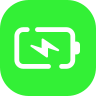
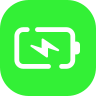
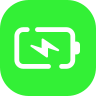
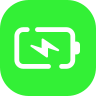
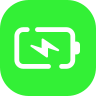
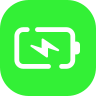
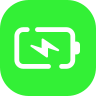
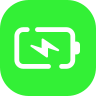
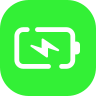
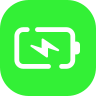
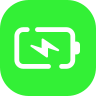
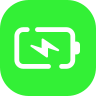
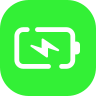
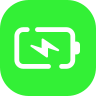
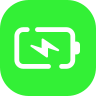
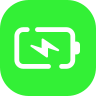
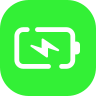
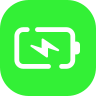
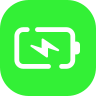
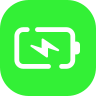
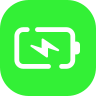
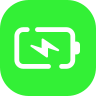
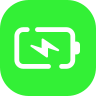
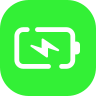
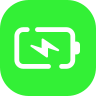
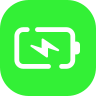
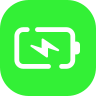
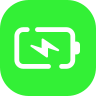
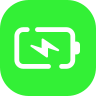
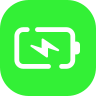
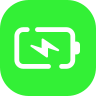
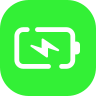
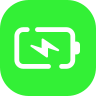
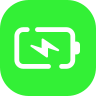
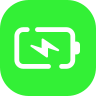
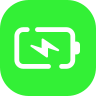
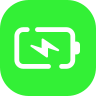
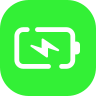
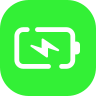
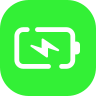
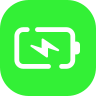
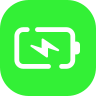
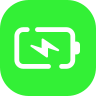
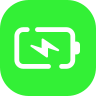
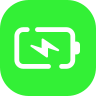
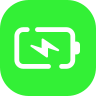
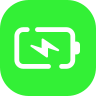
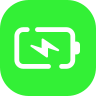
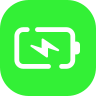
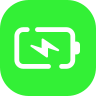
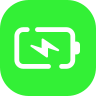
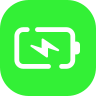
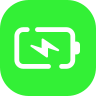
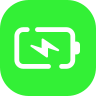
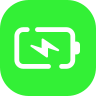
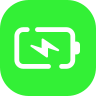
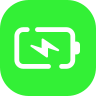
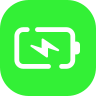
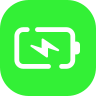
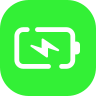
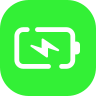
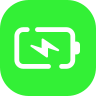
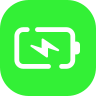
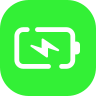
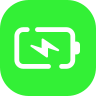
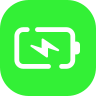
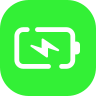
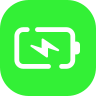
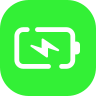
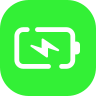
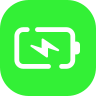
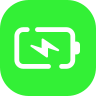
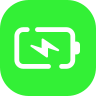
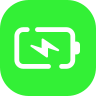
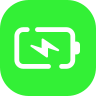
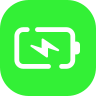
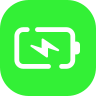
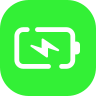
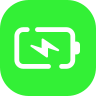
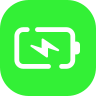
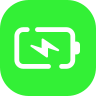
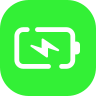
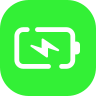
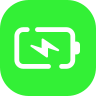
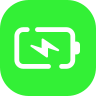
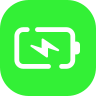
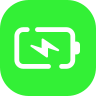
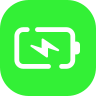
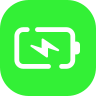
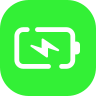
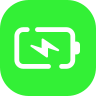
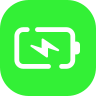
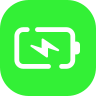
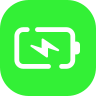
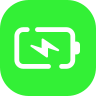
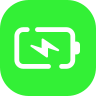
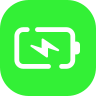
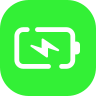
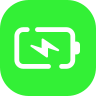
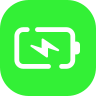
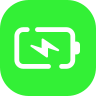
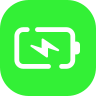
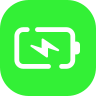
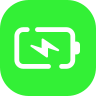
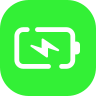
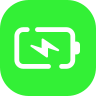
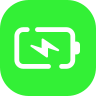
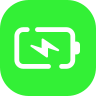
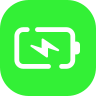
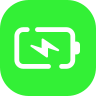
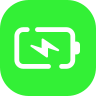
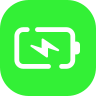
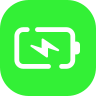
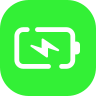
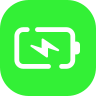
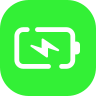
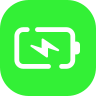
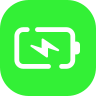
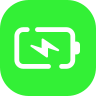
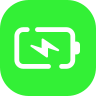
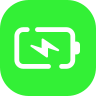
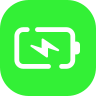
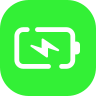
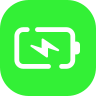
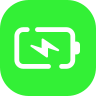
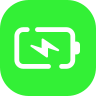
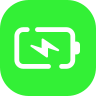
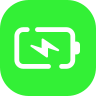
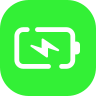
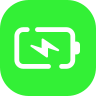
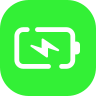
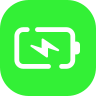
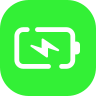
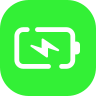
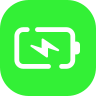
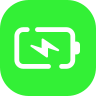
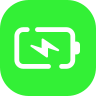
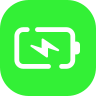
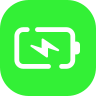
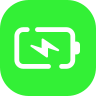
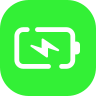
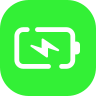
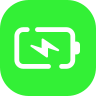
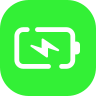
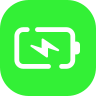
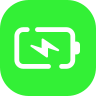
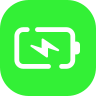
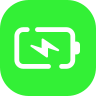
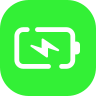
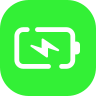
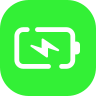
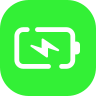
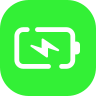
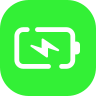
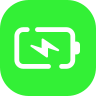
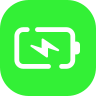
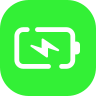
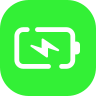
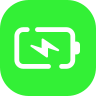
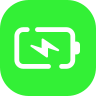
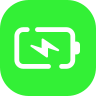
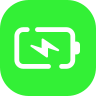
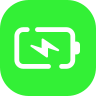
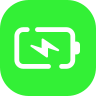
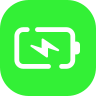
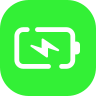
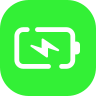
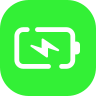
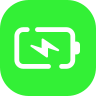
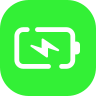
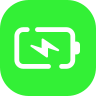
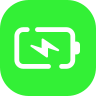
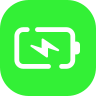
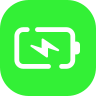
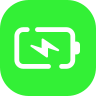
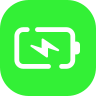
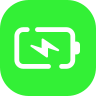
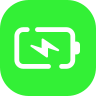
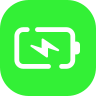
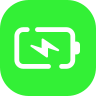
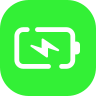
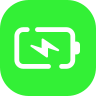
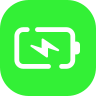
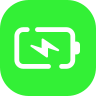
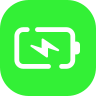
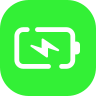
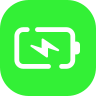
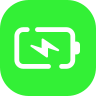
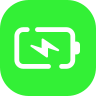
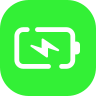
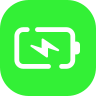
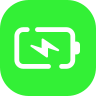
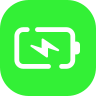
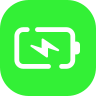
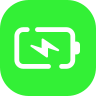
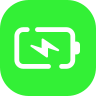
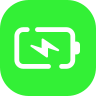
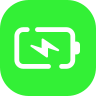
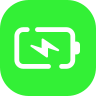
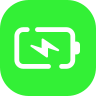
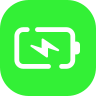
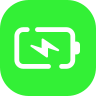
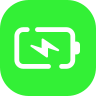
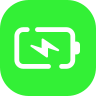
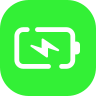
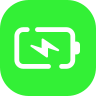
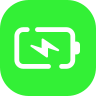
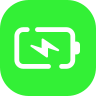
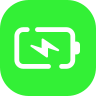
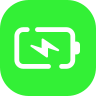
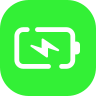
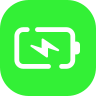
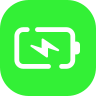
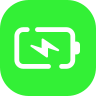
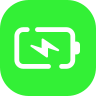
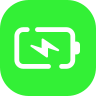
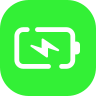
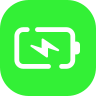
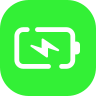
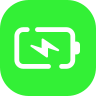
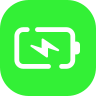
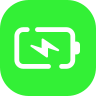
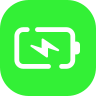
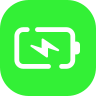
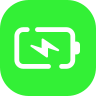
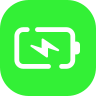
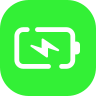
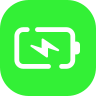
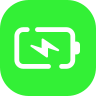
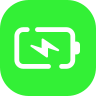
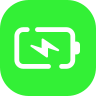
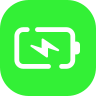
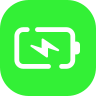
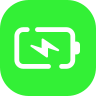
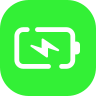
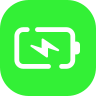
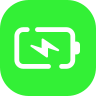
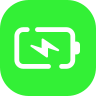
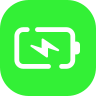
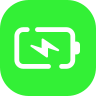
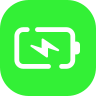
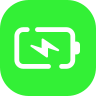
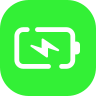
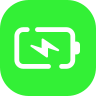
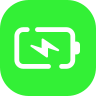
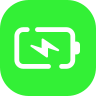
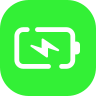
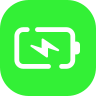
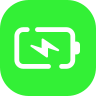
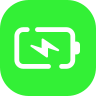
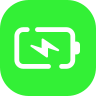
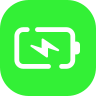
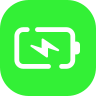
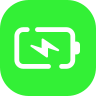
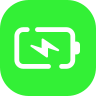
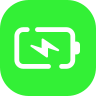
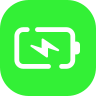
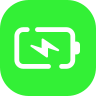
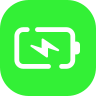
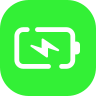
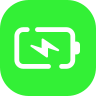
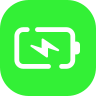
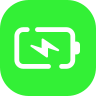
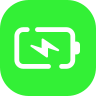
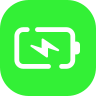
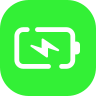
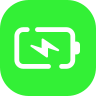
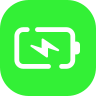
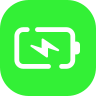
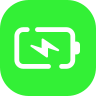
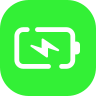
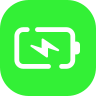
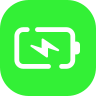
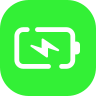
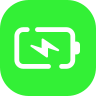
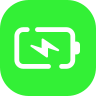
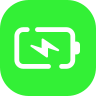
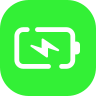
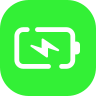
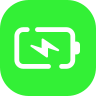
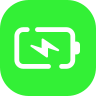
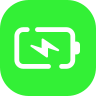
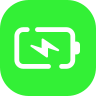
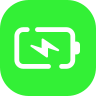
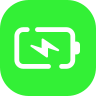
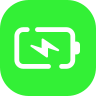
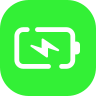
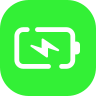
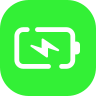
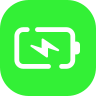
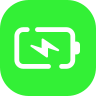
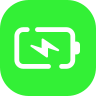
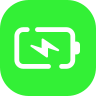
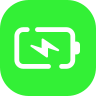
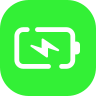
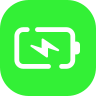
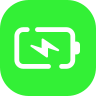
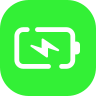
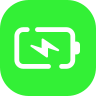
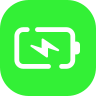
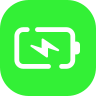
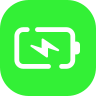
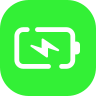
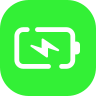
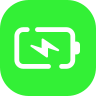
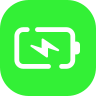
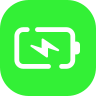
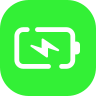
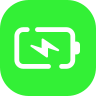
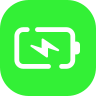
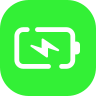
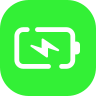
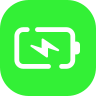
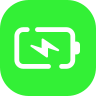
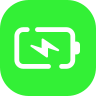
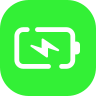
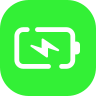
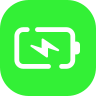
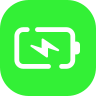
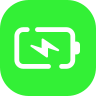
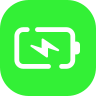
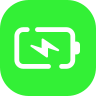
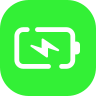
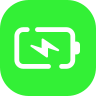
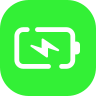
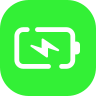
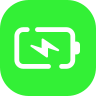
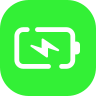
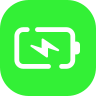
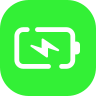
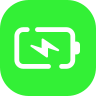
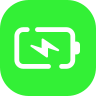
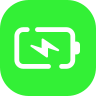
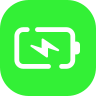
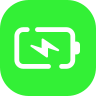
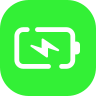
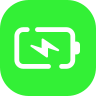
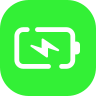
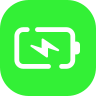
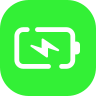
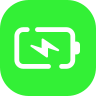
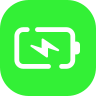
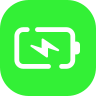
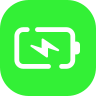
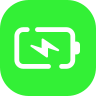
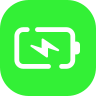
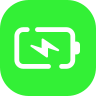
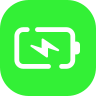
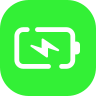
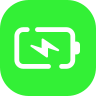
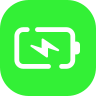
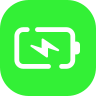
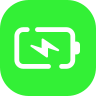
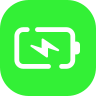
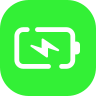
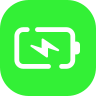
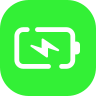
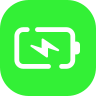
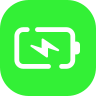
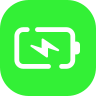
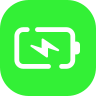
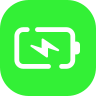
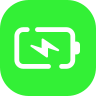
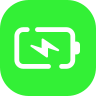
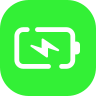
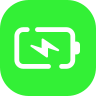
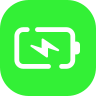
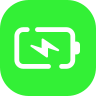
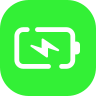
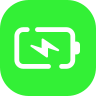
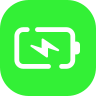
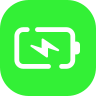
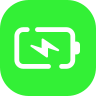
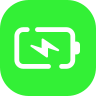
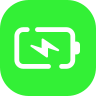
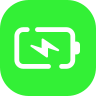
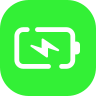
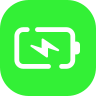
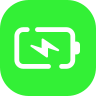
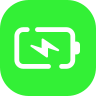
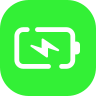
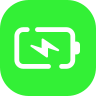
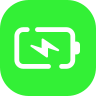
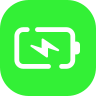
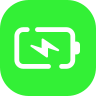
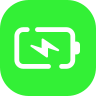
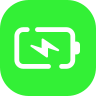
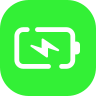
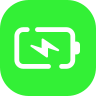
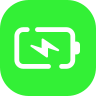
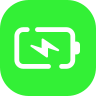
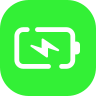
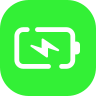
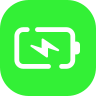
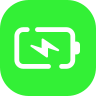
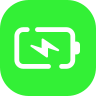
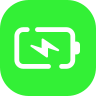
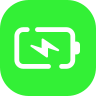
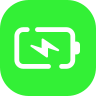
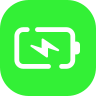
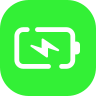
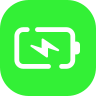
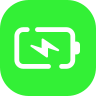
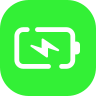
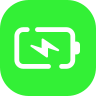

In [20]:
# Create a folium map centered around the average latitude and longitude
map_center = [df_plot['Latitude'].mean(), df_plot['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)


for _, row in df_plot.loc[df_plot["Tipo"]=="Estação de Recarga"].iterrows():
    folium.Marker(
      location=(row['Latitude'], row['Longitude']),
      icon=folium.features.CustomIcon("../resources/Ponto de Recarga.png",icon_size=(15,15)),
    ).add_to(m)
# Add circle markers for each customer
for _, row in df_plot.loc[df_plot["Tipo"]=="Cliente"].iterrows():
    folium.CircleMarker(
      location=(row['Latitude'], row['Longitude']),
      radius=row['Demanda']/25,
      color='blue',
      fill=True,
      fill_color='blue',
      fill_opacity=0.2
    ).add_to(m)


# Display the map
m